# NammaMetro Ridership EDA

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

filename = "NammaMetro_Ridership_Dataset.csv"
df = pd.read_csv(filename, index_col=0)

#### Let's take a closer look at the daily ridership data that NammaMetro publishes

Source: [https://english.bmrc.co.in/ridership/](https://english.bmrc.co.in/ridership/)

The Namma Metro Ridership stats page publishes a breakdown of payment methods used daily by passengers entering the system.

![ridership_plot](nammametro_datapage.png)

### Earliest Record

In [2]:
df.head(1)

,Record Date,Total Smart Cards,Stored Value Card,One Day Pass,Three Day Pass,Five Day Pass,Tokens,Total NCMC,Group Ticket,Total QR,QR NammaMetro,QR WhatsApp,QR Paytm
0,26-10-2024,353460,352496,853,43,68,241883,7444,512,177279,49351,95571,32357


### Most Recent Record

In [3]:
df.tail(1)

,Record Date,Total Smart Cards,Stored Value Card,One Day Pass,Three Day Pass,Five Day Pass,Tokens,Total NCMC,Group Ticket,Total QR,QR NammaMetro,QR WhatsApp,QR Paytm
42,13-12-2024,451688,450734,582,249,123,230188,12238,325,195704,56657,104783,34264


#### Extend the table with two useful columns: `Day of Week` and `Total Riders`

In [4]:
df['Total Riders'] = df.loc[:, ['Total Smart Cards', 'Tokens', 'Total NCMC', 'Group Ticket', 'Total QR']].sum(axis=1)
df['Record Date'] = pd.to_datetime(df['Record Date'], format='%d-%m-%Y')
df['Day of Week'] = df['Record Date'].dt.day_name()

df[['Record Date', 'Day of Week', 'Total Riders']].tail()

,Record Date,Day of Week,Total Riders
38,2024-12-09,Monday,895461
39,2024-12-10,Tuesday,903928
40,2024-12-11,Wednesday,794230
41,2024-12-12,Thursday,883218
42,2024-12-13,Friday,890143


## Passenger Flow: First Glance

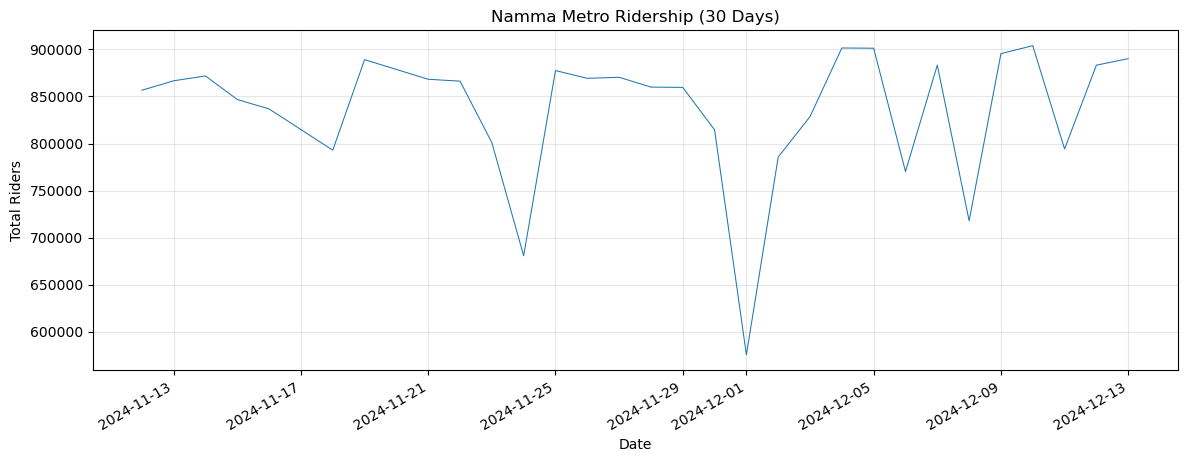

In [5]:
df.tail(30).plot(figsize=(14,5), 
                    kind='line', 
                    x='Record Date', 
                    xlabel='Date', 
                    y='Total Riders', 
                    ylabel='Total Riders', 
                    title='Namma Metro Ridership (30 Days)', 
                    legend=False,
                    linestyle='-',  # Solid line
                    linewidth=0.75)  # Thicker line
plt.grid(True, alpha=0.3)  # Optional: adds a light grid
plt.show()

### Let's make a cleaner graph for the last N days of available data.

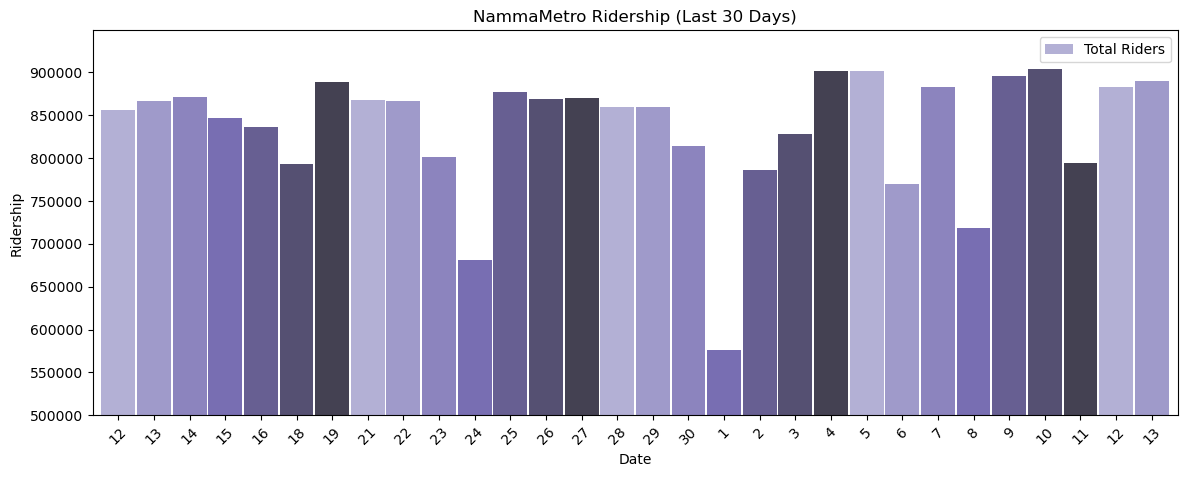

In [6]:
number_of_days = 30
Last_N_Days = df[['Record Date', 'Total Riders']].tail(number_of_days)
Last_N_Days['Record Date'] = pd.to_datetime(Last_N_Days['Record Date'], format='%d-%m-%Y').dt.day
Last_N_Days.plot(x='Record Date', 
                 y='Total Riders', 
                 kind='bar', 
                 xlabel='Date', 
                 ylabel='Ridership', 
                 title='NammaMetro Ridership (Last 30 Days)', 
                 figsize=(14,5), 
                 width=0.95,
                 legend=True,
                 color=sns.color_palette('Purples_d', 7),
                 rot=45)
plt.ylim(bottom=500000)
plt.show()

### Note the gaps in the data. 
NammaMetro fails to report ridership numbers on some days. Is someone updating the page manually?! 
Let's get a better understanding of that missing data.

In [7]:
from datetime import date, timedelta

start_date = date.today() - timedelta(number_of_days, 0, 0)
dates = pd.DataFrame({'Record Date': [str(start_date+timedelta(n)) for n in range(number_of_days)]})
dates['Record Date'] = pd.to_datetime(dates['Record Date'], format='%Y-%m-%d')

print(f"We will examine the data for an interval of the last {number_of_days} days, \
i.e. from {dates['Record Date'].min().strftime('%d-%m-%Y')} to {dates['Record Date'].max().strftime('%d-%m-%Y')}.")

We will examine the data for an interval of the last 30 days, i.e. from 14-11-2024 to 13-12-2024.


#### Missing Days

In [8]:
Last_N_Days = df.merge(dates, how='right', on='Record Date')
Last_N_Days.drop(['Stored Value Card', 'One Day Pass', 'Three Day Pass', 'Five Day Pass', 'QR NammaMetro', 'QR WhatsApp', 'QR Paytm'], axis=1, inplace=True)
Last_N_Days.rename(columns={'Total Smart Cards':'Smart Cards', 'Total NCMC':'NCMC', 'Total QR':'QR'}, inplace=True)

formatted_dates = pd.to_datetime(Last_N_Days['Record Date'], format='%Y-%m-%d').dt.strftime('%d')
formatted_numbers = Last_N_Days.loc[:, 'Smart Cards':'Total Riders'].astype('Int64')
formatted_dow = pd.to_datetime(Last_N_Days['Record Date'], format='%Y-%m-%d').dt.day_name()

Last_N_Days_1 = pd.concat([formatted_dates, formatted_numbers, formatted_dow], axis=1)
Last_N_Days_1[Last_N_Days_1['Smart Cards'].isnull()]

,Record Date,Smart Cards,Tokens,NCMC,Group Ticket,QR,Total Riders,Record Date
3,17,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Sunday
6,20,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Wednesday


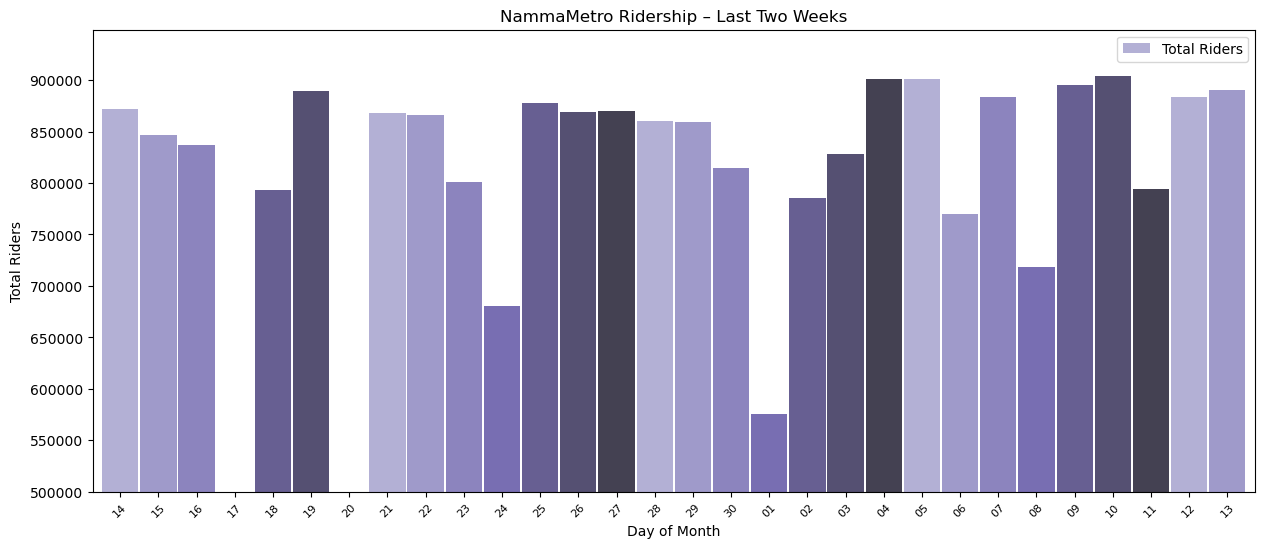

In [9]:
Last_N_Days_1.loc[:, :'Total Riders']\
           .plot(x='Record Date',
                 y='Total Riders',
                 kind='bar',
                 xlabel='Day of Month',
                 ylabel='Total Riders',
                 title='NammaMetro Ridership – Last Two Weeks', 
                 figsize=(15,6),
                 width=0.95,
                 color=sns.color_palette('Purples_d', 7),
                 legend=True,
                 rot=45)
plt.ylim(bottom=500000)
plt.xticks(fontsize=8)
plt.yticks(fontsize=10)
plt.show()

### Looks like a mouth with a few broken teeth!

What sort of data imputation makes sense here? 

When the dataset grows large enough over several months, it makes sense to fill unreported dates with an average of similar days, e.g. If a weekday Tuesday was missing, take the average of the last 4 available weekday Tuesdays.

## Smart Cards and Tokens are very popular with the public

#### Prepare the data to plot a bar chart stacked by access method

In [10]:
Last_N_Days_2 = Last_N_Days.melt(
                    id_vars=['Record Date'], 
                    value_vars=['Smart Cards', 'Tokens', 'NCMC', 'Group Ticket', 'QR'], 
                    var_name='Access Method', 
                    value_name='Count').sort_values(by=['Record Date', 'Access Method'])
Last_N_Days_2 = Last_N_Days_2[['Record Date', 'Access Method', 'Count']].sort_values(by=['Record Date', 'Access Method'], ignore_index=True)

formatted_dates = pd.to_datetime(Last_N_Days_2['Record Date'], format='%Y-%m-%d').dt.strftime('%d')
formatted_numbers = Last_N_Days_2.loc[:, 'Count'].astype('Int64')

Last_N_Days_2 = pd.concat([formatted_dates, Last_N_Days_2['Access Method'], formatted_numbers], axis=1)
Last_N_Days_2

,Record Date,Access Method,Count
0,14,Group Ticket,348
1,14,NCMC,11858
2,14,QR,180760
3,14,Smart Cards,471099
4,14,Tokens,207693
...,...,...,...
145,13,Group Ticket,325
146,13,NCMC,12238
147,13,QR,195704
148,13,Smart Cards,451688


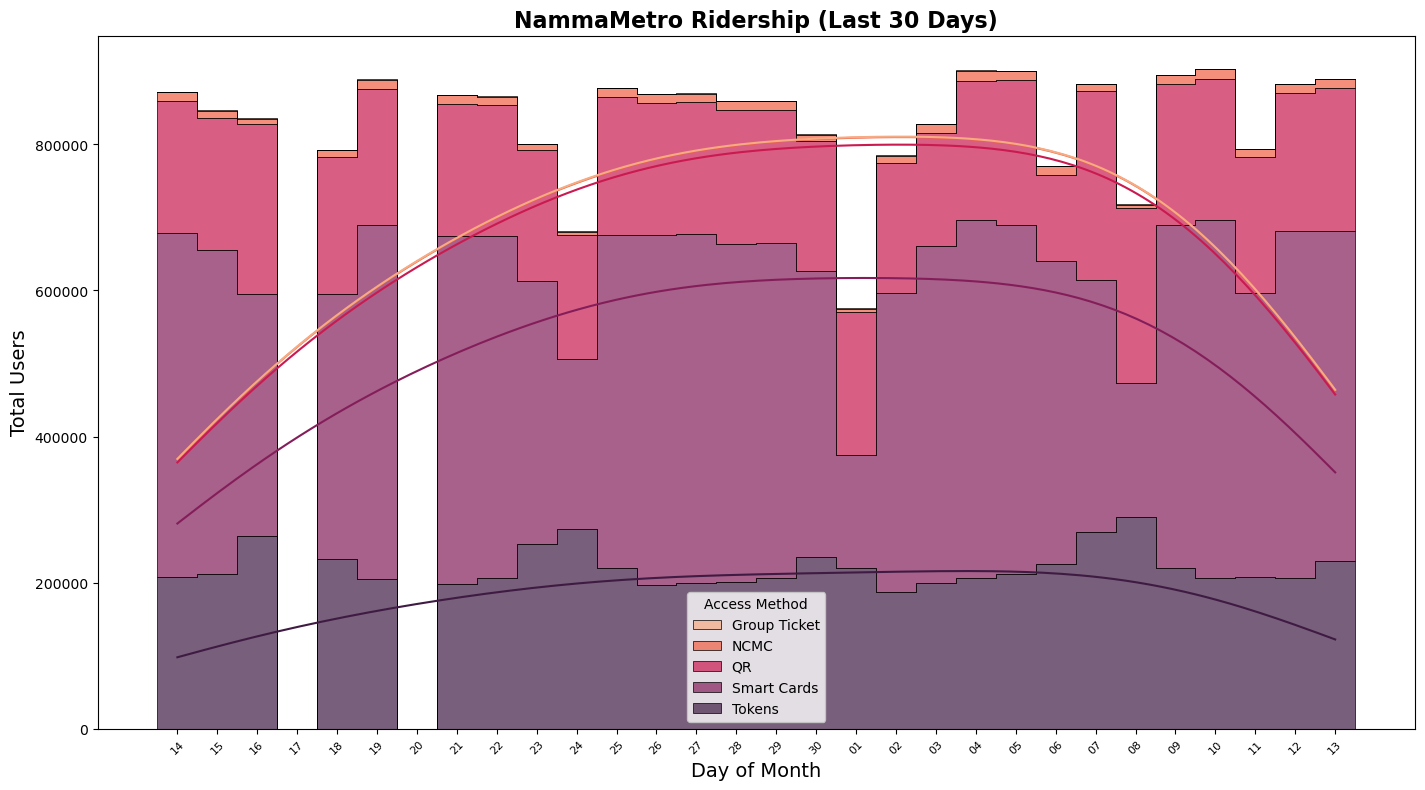

In [11]:
plt.figure(figsize=(17,9))
sns.histplot(data=Last_N_Days_2,    x='Record Date',
             weights='Count',       bins=number_of_days,
             hue='Access Method',   multiple='stack', 
             element='step',        palette='rocket_r',
             legend=True,           common_norm=True,
             stat='count',          linewidth=0.5,
             alpha=0.7,             discrete=True, 
             kde=True)
plt.xlabel('Day of Month', fontsize=14)
plt.ylabel('Total Users', fontsize=14)
plt.title(f'NammaMetro Ridership (Last {number_of_days} Days)', fontsize=16, fontweight='bold')
plt.xticks(rotation=45)
plt.xticks(fontsize=8)
plt.yticks(fontsize=10)
plt.show()

## NammaMetro on any given week

In [12]:
df['Record Date'] = pd.to_datetime(df['Record Date'], format='%Y-%m-%d')
df['Day of Week'] = df['Record Date'].dt.day_name()
df['Day of Week'].value_counts()[['Sunday', 'Saturday', 'Friday', 'Thursday', 'Wednesday', 'Tuesday', 'Monday']]

Day of Week
Sunday       6
Saturday     7
Friday       6
Thursday     5
Wednesday    6
Tuesday      7
Monday       6
Name: count, dtype: int64

In [13]:
weekly_average = df.merge(dates, how='right', on='Record Date')
weekly_average.drop(['Stored Value Card', 'One Day Pass', 'Three Day Pass', 'Five Day Pass', 'QR NammaMetro', 'QR WhatsApp', 'QR Paytm'], axis=1, inplace=True)
weekly_average.rename(columns={'Total Smart Cards':'Smart Cards', 'Total NCMC':'NCMC', 'Total QR':'QR'}, inplace=True)

weekly_average = weekly_average.groupby('Day of Week')[['Smart Cards', 'Tokens', 'NCMC', 'Group Ticket', 'QR']].mean()
weekly_average = weekly_average.loc[['Sunday', 'Saturday', 'Friday', 'Thursday', 'Wednesday', 'Tuesday', 'Monday']]

for col in ['Smart Cards', 'Tokens', 'NCMC', 'Group Ticket', 'QR']:
    weekly_average[col] = pd.to_numeric(weekly_average[col].fillna(0), errors='coerce').round().astype('Int64')

weekly_average = weekly_average[['Smart Cards', 'Tokens', 'NCMC', 'Group Ticket', 'QR']]
weekly_average

,Smart Cards,Tokens,NCMC,Group Ticket,QR
Day of Week,,,,,
Sunday,190070,261481,4518,641,201466
Saturday,357430,254787,8227,1025,212432
Friday,447772,215811,11471,663,170901
Thursday,472956,204779,12282,569,186298
Wednesday,452747,204288,11926,744,185658
Tuesday,479156,201555,12568,562,178892
Monday,424840,214524,10852,668,186992


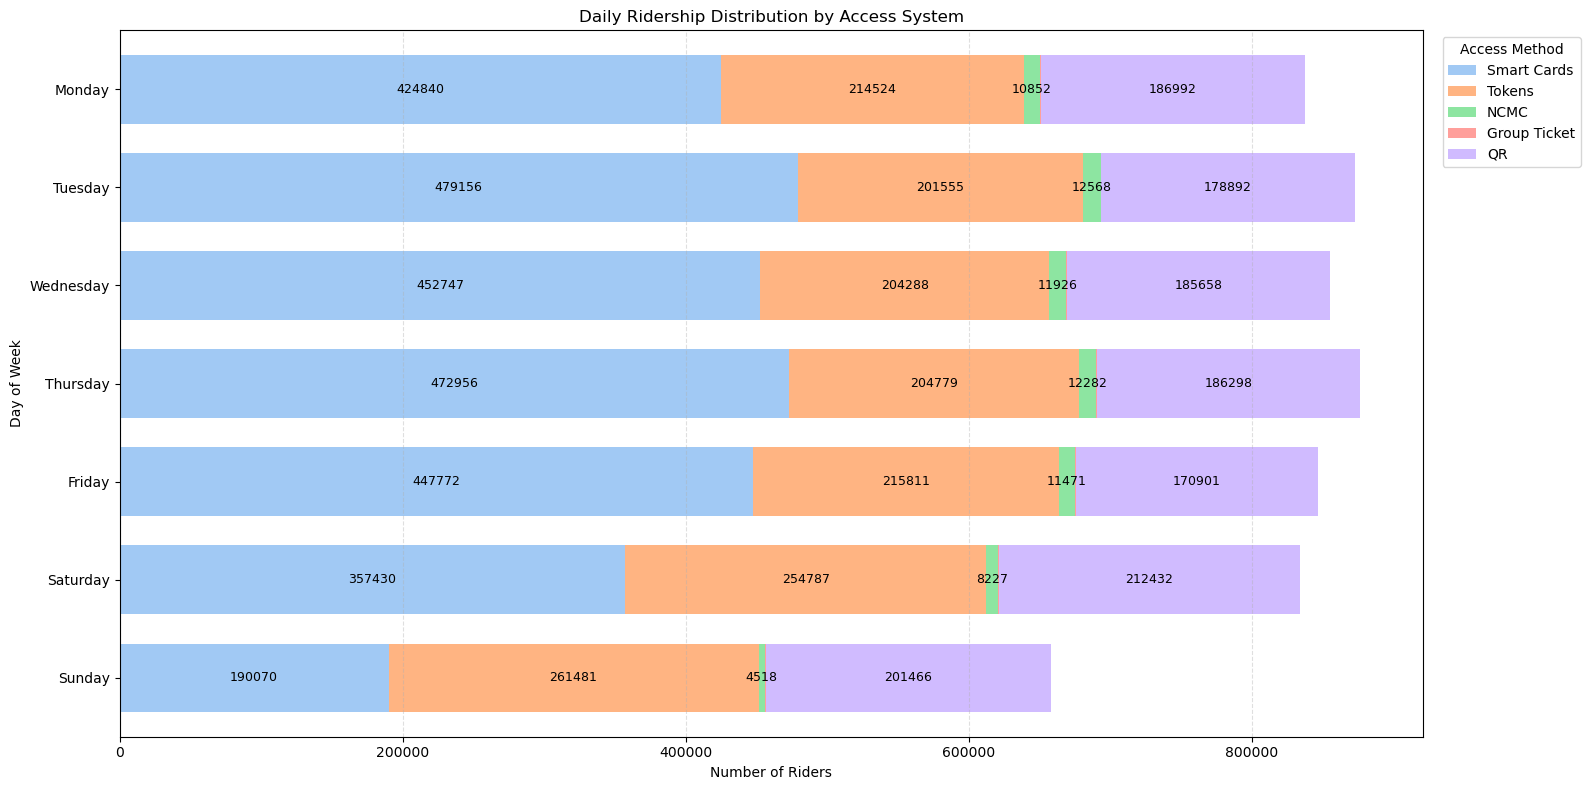

In [14]:
ax = weekly_average.plot(kind='barh', 
                         stacked=True,
                         color=sns.color_palette('pastel', 5),
                         figsize=(16, 8),
                         width=0.7,
                         rot=0)

plt.title('Daily Ridership Distribution by Access System')
plt.ylabel('Day of Week')
plt.xlabel('Number of Riders')
plt.legend(title='Access Method', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.grid(axis='x', linestyle='--', alpha=0.4)

# Show labels for segments based on condition
for c in ax.containers:
    labels = ['%.0f' % v if v >= 1250 else '' for v in c.datavalues]
    ax.bar_label(c, labels=labels, label_type='center', fontsize=9)

plt.tight_layout()
plt.show()

_____

## The Metro is Getting Crowded

### Top 10 Busiest Days

In [15]:
busiest_days = df[['Record Date', 'Total Riders', 'Day of Week']].sort_values('Total Riders', ascending=False)
busiest_days.reset_index(drop=True, inplace=True)
busiest_days.index = range(1, len(busiest_days) + 1)
busiest_days.head(10)

,Record Date,Total Riders,Day of Week
1,2024-12-10,903928,Tuesday
2,2024-12-04,901475,Wednesday
3,2024-12-05,901230,Thursday
4,2024-12-09,895461,Monday
5,2024-12-13,890143,Friday
6,2024-11-19,889113,Tuesday
7,2024-12-07,883300,Saturday
8,2024-12-12,883218,Thursday
9,2024-11-11,878225,Monday
10,2024-11-25,877496,Monday


### 👆🏼 In December 2024, NammaMetro daily ridership crossed 900,000 for the first time!

### Least Busy Days so far

In [16]:
busiest_days.tail(10)

,Record Date,Total Riders,Day of Week
34,2024-12-06,770287,Friday
35,2024-11-09,748885,Saturday
36,2024-12-08,717975,Sunday
37,2024-11-24,680853,Sunday
38,2024-11-10,654523,Sunday
39,2024-10-27,637048,Sunday
40,2024-12-01,575702,Sunday
41,2024-11-03,536524,Sunday
42,2024-11-02,480284,Saturday
43,2024-11-01,404342,Friday


### 👆🏼 NammaMetro is more popular for the weekday work commute than for getting around on the weekends 

### By Quartile

In [17]:
N = 75
Nth_quantile = busiest_days['Total Riders'].quantile(N/100)
busiest_days[busiest_days['Total Riders'] > Nth_quantile].value_counts('Day of Week')

Day of Week
Monday       3
Thursday     3
Tuesday      2
Friday       1
Saturday     1
Wednesday    1
Name: count, dtype: int64

### 👆🏼 Manic Mondays

Mondays are most frequent in the 4th Quartile whereas

### 👇🏼 Weekends begin on Friday

Traffic eases down starting Friday

In [18]:
N = 25
Nth_quantile = busiest_days['Total Riders'].quantile(N/100)
busiest_days[busiest_days['Total Riders'] < Nth_quantile].value_counts('Day of Week')

Day of Week
Sunday      6
Saturday    3
Friday      2
Name: count, dtype: int64